# Installation Instructions

Clone the repos, install dependencies and install packages terrapin, quest and gsshapy.

Note: terrapin isn't used in this example but it will be in future examples...

```bash
git clone git@public.git.erdc.dren.mil:computational-analysis-and-mechanics/quest.git
git clone git@public.git.erdc.dren.mil:computational-analysis-and-mechanics/terrapin.git
git clone git@github.com:CI-WATER/gsshapy.git

conda env create -n earthsim -f ./terrapin/py3_conda_environment.yml
conda env update -n earthsim -f ./quest/py3_conda_environment.yml
conda env update -n earthsim -f ./gsshapy/conda_env.yml
source activate earthsim

cd terrapin
python setup.py develop
cd ../quest
python setup.py develop
cd ../gsshapy
python setup.py develop
```


In [41]:
%matplotlib inline
from datetime import datetime, timedelta
import os

import geopandas as gpd
from gsshapy.modeling import GSSHAModel
import quest
from matplotlib import colors, cm, pyplot as plt
from gazar import grid
import numpy as np

Function to automate the downloading process:

In [2]:
def download_data(service_uri, bounds, collection_name):
    """
    Downloads raster data from source uri and adds to a quest collection.
    
    If multiple raster tiles are retrieved for the given bounds it calls a quest 
    filter to merge the tiles into a single raster.
    
    Returns quest uid for merged raster
    """
    
    # download the features (i.e. locations) and metadata for the given web service
    # the first time this is run it will take longer since it downloads 
    # and caches all metadata for the given service.
    features = quest.api.get_features(uris=service_uri,
                                      filters={'bbox': bounds},
                                      as_dataframe=True,
                                      )
    
    # add the selected features to a quest collection
    added_features = quest.api.add_features(collection_name, features)
    
    # stage the data for download, optional parameters can be provided here 
    # for certain web services (i.e. date range etc), raster services don't 
    # typically have any optional parameters.
    staged_datasets = quest.api.stage_for_download(uris=added_features)
    
    # download the staged datasets
    quest.api.download_datasets(datasets=staged_datasets)
    final_dataset = staged_datasets
    
    # if more than one raster tile downloaded, merge into a single raster tile
    if len(staged_datasets) > 1:
        merged_datasets = quest.api.apply_filter(name='raster-merge',
                                                 datasets=staged_datasets)
        final_dataset = merged_datasets['datasets']
        # delete the original individual tiles
        quest.api.delete(staged_datasets)

    return final_dataset

Parameters to change for the run:

In [3]:
elevation_service = 'svc://usgs-ned:13-arc-second'
land_use_service = 'svc://usgs-nlcd:2011'
land_use_grid_id = 'nlcd'
base_dir = os.getcwd() # path needs to be absolute for gsshapy
boundary_shapefile = os.path.join(base_dir, 'vicksburg_watershed', 'watershed_boundary.shp')
gssha_model_name = 'vicksburg_south_with_delineation'
gssha_model_directory = os.path.join(base_dir, gssha_model_name)

Get the download boundary from the shapefile:

In [4]:
boundary_gpd = gpd.read_file(boundary_shapefile)
bounds = [str(x) for x in boundary_gpd.geometry.bounds.values[0]]

The collection is where we will origanize the downloaded data.

In [5]:
try:
    quest.api.new_collection(gssha_model_name)
except ValueError as e:
    print(e)

Download the data. This may take some time.

In [6]:
elevation = download_data(elevation_service, bounds, gssha_model_name)

... ... .img format raster saved at /Users/rditldp9/Library/Application Support/quest/projects/default/vicksburg_south_with_delineation/dbafa80f14634994ae218328525bc5d0.img
... ... .img format raster saved at /Users/rditldp9/Library/Application Support/quest/projects/default/vicksburg_south_with_delineation/d131979deb5d4cea84d56dadfaee5738.img


In [42]:
def watershed_delineation(elevation, outlet):
    # run pit filling algorithm
    algorithm = 'go-fill'  # one of ['flats', 'go-fill', 'go-breach']
    result = quest.api.apply_filter('raster-fill', datasets=elevation, options={'algorithm': algorithm})
    pit_filled = result['datasets'][0]
    
    # run flow accumulation
    algorithm = 'go-d8'  # one of ['d8', 'go-d8', 'go-fd8']
    result = quest.api.apply_filter('raster-flow-accumulation', datasets=pit_filled, options={'algorithm': algorithm})
    flow_accumulation = result['datasets'][0]
    
    # generate delineation
    result = quest.api.apply_filter('raster-watershed-delineation', datasets=flow_accumulation, 
                       options={'outlet_points': outlet, 'snap_outlets': 'jenson', 'stream_threshold_pct': 0.1})
    return result['features']['watershed'], result['features']['outlet'], flow_accumulation

In [ ]:
# use the merged raster to create a shapefile
outlet = [(-91.058, 32.0498)]
watershed, outlet, flow_accumulation = watershed_delineation(elevation, outlet)

Setting up go-spatial tool: FillDepressions
Running process...


In [26]:
## read in flow accumulation
# flow_accumulation_file = quest.api.get_metadata(flow_accumulation)[flow_accumulation]['file_path']
# flow_accumulation_dataset = grid.GDALGrid(flow_accumulation_file)
# flow_accumulation_data = flow_accumulation_dataset.np_array()

# max_accumulation = flow_accumulation_data.max()
# stream_threshold = max_accumulation * 0.01
# rivers = np.ma.masked_where(flow_accumulation_data < stream_threshold, flow_accumulation_data)

In [37]:
quest.api.get_metadata(elevation[0])[elevation[0]]

{'collection': 'vicksburg_south_with_delineation',
 'created_at': Timestamp('2017-06-09 07:32:04.157852'),
 'datatype': 'raster',
 'description': 'Raster Filter Applied',
 'display_name': 'Created by filter raster-merge',
 'feature': 'f01d77139cac4533bf921eee2d96ad69',
 'file_format': 'raster-gdal',
 'file_path': '/Users/rditldp9/Library/Application Support/quest/projects/default/vicksburg_south_with_delineation/deb7d3a7784043f58e6eaa9ececb154f/deb7d3a7784043f58e6eaa9ececb154f.tif',
 'message': '',
 'metadata': {},
 'name': 'deb7d3a7784043f58e6eaa9ececb154f',
 'options': {'dataset': ['d7dc56f3d48946b7926d95d83c8382cc',
   'd57fab8941f3466bbe6424313c649224'],
  'features': None,
  'filter_applied': 'raster-merge',
  'filter_options': None},
 'parameter': 'elevation',
 'source': 'derived',
 'status': 'filter applied',
 'unit': '',
 'updated_at': None,
 'visualization_path': ''}

In [38]:
# read in elevation data
dem_file = quest.api.get_metadata(elevation[0])[elevation[0]]['file_path']
dem = grid.GDALGrid(dem_file)
lat, lon = dem.latlon

KeyboardInterrupt: 

4.639830471741642e-08 array('d', [-91.05796296330512]) array('d', [32.04981481515537])


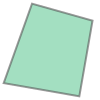

In [17]:
watershed_geometry = quest.api.get_metadata(watershed)[watershed]['geometry']
outlet_lon, outlet_lat = quest.api.get_metadata(outlet)[outlet]['geometry'].coords.xy
print(watershed_geometry.area, outlet_lon, outlet_lat)
watershed_geometry


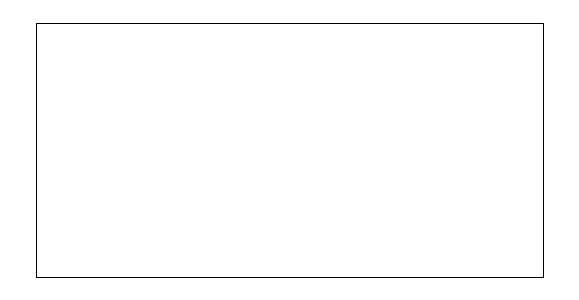

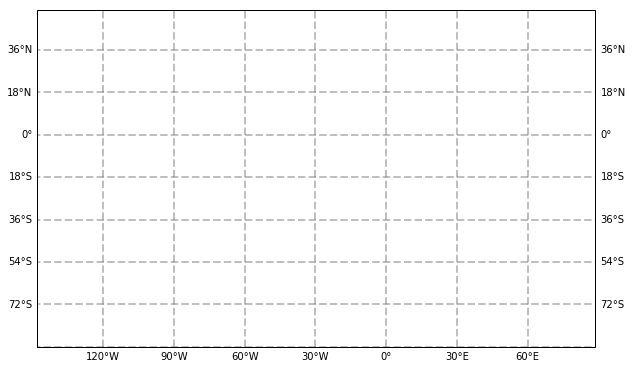

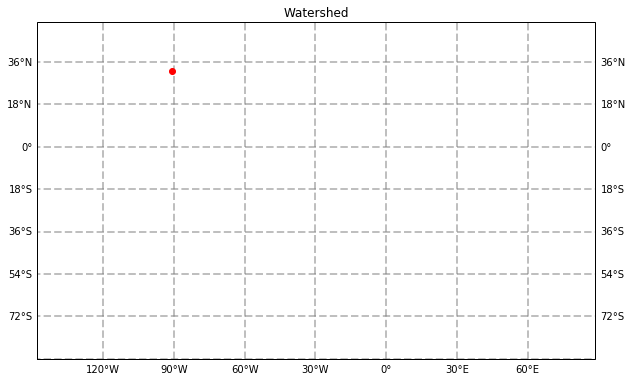

In [15]:
# plot the generated watershed with outlet point
watershed_geometry = quest.api.get_metadata(watershed)[watershed]['geometry']
outlet_lon, outlet_lat = quest.api.get_metadata(outlet)[outlet]['geometry'].coords.xy

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib import colors, cm, pyplot as plt

display_bbox = [float(b) for b in bounds]
graticule_spacing = 0.01

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent(display_bbox)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_top = False

#plt.contourf(lon, lat, dem.np_array(), 100, zorder=2, cmap=cm.terrain, transform=ccrs.PlateCarree())
#ax.imshow(rivers, cmap=cm.ocean, origin='lower', zorder=3)
watershed_shp = cfeature.ShapelyFeature([watershed_geometry], ccrs.PlateCarree())
ax.add_feature(watershed_shp, zorder=4, alpha=0.6)
ax.scatter(x=outlet_lon, y=outlet_lat, color='red', zorder=5, transform=ccrs.PlateCarree())
plt.title("Watershed")
plt.show()

In [ ]:
land_use_file_path = download_data(land_use_service, bounds, gssha_model_name)

Use the data to generate a GSSHA model. This may take a minute.

In [ ]:
# make the directory for the output
try:
    os.mkdir(gssha_model_directory)
except OSError:
    pass

# generate GSSHA model files
model = GSSHAModel(project_name=gssha_model_name,
                   project_directory=gssha_model_directory,
                   mask_shapefile=boundary_shapefile,
                   elevation_grid_path=elevation_file_path,
                   land_use_grid=land_use_file_path,
                   land_use_grid_id=land_use_grid_id,
                   out_hydrograph_write_frequency=1,
                   )

# add card for max depth
model.project_manager.setCard('FLOOD_GRID',
                              '{0}.fgd'.format(gssha_model_name),
                              add_quotes=True)
# TODO: Add depth grids to simulation
# MAP_FREQ, DEPTH

# add event for simulation
model.set_event(simulation_start=datetime.utcnow(),
                simulation_duration=timedelta(seconds=2*60),
                rain_intensity=24,
                rain_duration=timedelta(seconds=1*60),
                )
model.write()

In [13]:
bounds

['-91.2291666667', '32.05', '-90.7833333333', '32.3708333333']